# Local
trying to train a local xgboost model

In [1]:
!python3 -m pip install pandas jupyter matplotlib pmdarima statsmodels


[notice] A new release of pip available: 22.2.1 -> 23.3
[notice] To update, run: python3.9 -m pip install --upgrade pip


In [2]:

import pandas as pd

### Common Functions

In [3]:
def add_lags(df, lag_cols, lag_num):
    for col in lag_cols:
        for i in range(1, lag_num + 1):
            df['{}_lag_{}'.format(col, i)] = df[col].shift(i)
    return df

#this is more stationary than price (or so the internet says)
def add_returns(df, price_col, price_lag_col):
    df['returns'] = (df[price_col] / df[price_lag_col] - 1) * 100
    return df

### Import Data

In [34]:
df = pd.read_csv("output.csv")

# Convert hourStartUnix to a datetime format (optional but could be useful)
df['hourStartUnix'] = pd.to_datetime(df['hourStartUnix'], unit='s')

#split by pairAddress
pair_addresses = df['pairAddress'].unique()
pair_data_dict = {addr: df[df['pairAddress'] == addr] for addr in pair_addresses}

for addr, data in pair_data_dict.items():
    #sort
    pair_data_dict[addr] = pair_data_dict[addr].sort_values(by='hourStartUnix').reset_index(drop=True)
    #add row number. we dont want to use timestamp
    pair_data_dict[addr]['row_num'] = pair_data_dict[addr].index + 1
    #price lag is needed to calculate returns
    pair_data_dict[addr] = add_lags(pair_data_dict[addr], ['price', 'hourlyTxns'], 2)
    # calculate returns
    pair_data_dict[addr] = add_returns(pair_data_dict[addr], 'price', 'price_lag_1')
    # add returns lag
    pair_data_dict[addr] = add_lags(pair_data_dict[addr], ['returns'], 2)

    #finally, drop all rows with nan values
    pair_data_dict[addr] = pair_data_dict[addr].dropna()


pair_data_dict['0x58c23378f238f3f35e972b50a95fcc5d4b8c94cf'].head()

,hourStartUnix,pairAddress,reserve0,reserve1,reserveUSD,hourlyVolumeToken0,hourlyVolumeToken1,hourlyVolumeUSD,hourlyTxns,price,row_num,price_lag_1,price_lag_2,hourlyTxns_lag_1,hourlyTxns_lag_2,returns,returns_lag_1,returns_lag_2
3,2023-07-18 23:00:00,0x58c23378f238f3f35e972b50a95fcc5d4b8c94cf,18.955859,4.387154e+13,72015.478067,88.122964,2.063554e+14,0.0,532,4.320765e-13,4,5.567617e-13,5.294746e-13,580.0,771.0,-22.394725,5.153627,154.102845
4,2023-07-19 00:00:00,0x58c23378f238f3f35e972b50a95fcc5d4b8c94cf,18.904216,4.442739e+13,72076.759901,56.995680,1.649182e+14,0.0,298,4.255081e-13,5,4.320765e-13,5.567617e-13,532.0,580.0,-1.520181,-22.394725,5.153627
5,2023-07-19 01:00:00,0x58c23378f238f3f35e972b50a95fcc5d4b8c94cf,26.912604,3.148628e+13,102814.135249,70.779072,1.080117e+14,0.0,410,8.547407e-13,6,4.255081e-13,4.320765e-13,298.0,532.0,100.875292,-1.520181,-22.394725
6,2023-07-19 02:00:00,0x58c23378f238f3f35e972b50a95fcc5d4b8c94cf,27.451263,3.136721e+13,104932.911402,156.635484,1.612589e+14,0.0,673,8.751580e-13,7,8.547407e-13,4.255081e-13,410.0,298.0,2.388711,100.875292,-1.520181
7,2023-07-19 03:00:00,0x58c23378f238f3f35e972b50a95fcc5d4b8c94cf,29.342702,2.959179e+13,112249.002152,76.661117,9.010680e+13,0.0,384,9.915825e-13,8,8.751580e-13,8.547407e-13,673.0,410.0,13.303254,2.388711,100.875292


### Train Model

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

regressor = xgb.XGBRegressor(objective ='reg:squarederror')  # 'reg:squarederror' is the default objective

#iterate over all pairs in pair_data_dict
for addr, data in pair_data_dict.items():
    test_data_frame = data.drop(columns=['pairAddress', 'hourStartUnix'])
    test_data_frame = test_data_frame.dropna()
    #print(test_data_frame.head())

    split_idx = int(len(test_data_frame) * 0.8)

    train_data = test_data_frame[:split_idx]
    test_data = test_data_frame[split_idx:]

    #print(train_data.head())


    X_train = train_data.drop(columns=['returns'])
    y_train = train_data['returns']
    X_test = test_data.drop(columns=['returns'])
    y_test = test_data['returns']


    regressor = xgb.XGBRegressor(objective ='reg:squarederror')  # 'reg:squarederror' is the default objective

In [39]:
#just a TEST!!!!!!!!!
#test training model with just a single pair
import xgboost as xgb
from sklearn.metrics import mean_squared_error

#pair_address = '0x58c23378f238f3f35e972b50a95fcc5d4b8c94cf';
pair_address = '0xb1a438dffb08422d7320b6191d57154b729972bb';

test_data_frame = pair_data_dict[pair_address].drop(columns=['pairAddress', 'hourStartUnix'])
test_data_frame = test_data_frame.dropna()
#print(test_data_frame.head())

split_idx = int(len(test_data_frame) * 0.8)

train_data = test_data_frame[:split_idx]
test_data = test_data_frame[split_idx:]

#print(train_data.head())


X_train = train_data.drop(columns=['returns'])
y_train = train_data['returns']
X_test = test_data.drop(columns=['returns'])
y_test = test_data['returns']


regressor = xgb.XGBRegressor(objective ='reg:squarederror')  # 'reg:squarederror' is the default objective

regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error: %.2f" % (mse))

Mean Squared Error: 120.06


/usr/local/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/usr/local/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/usr/local/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/usr/local/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/usr/local/lib/py

#### Test Plots

/var/folders/fl/66f75xc55s94z_5527k5vch80000gn/T/ipykernel_97728/3451414558.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predictions'] = y_pred
/var/folders/fl/66f75xc55s94z_5527k5vch80000gn/T/ipykernel_97728/3451414558.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['pairAddress'] = '0x58c23378f238f3f35e972b50a95fcc5d4b8c94cf'
/var/folders/fl/66f75xc55s94z_5527k5vch80000gn/T/ipykernel_97728/3451414558.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

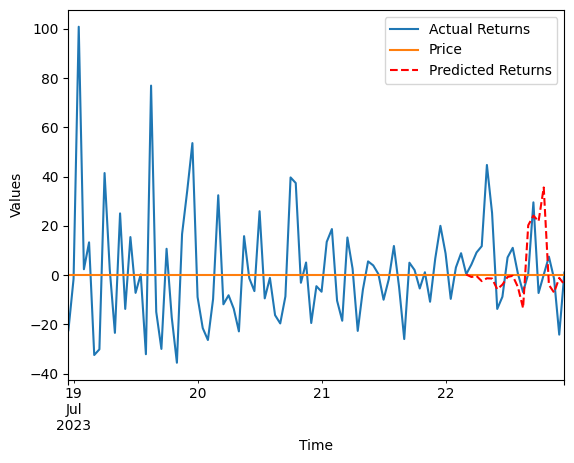

In [40]:
import matplotlib.pyplot as plt

test_data['predictions'] = y_pred
#add back in the pair address and hourStartUnix to test_data and train_data
train_data['pairAddress'] = '0x58c23378f238f3f35e972b50a95fcc5d4b8c94cf'
train_data['hourStartUnix'] = pair_data_dict['0x58c23378f238f3f35e972b50a95fcc5d4b8c94cf']['hourStartUnix'][:split_idx]
test_data['pairAddress'] = '0x58c23378f238f3f35e972b50a95fcc5d4b8c94cf'
test_data['hourStartUnix'] = pair_data_dict['0x58c23378f238f3f35e972b50a95fcc5d4b8c94cf']['hourStartUnix'][split_idx:]
merged_data = pd.concat([train_data, test_data])  # Assuming train_data is your training data DataFrame

# Get the axis object from the first plot
ax = pair_data_dict['0x58c23378f238f3f35e972b50a95fcc5d4b8c94cf'].plot(x='hourStartUnix', y='returns', label='Actual Returns')

# Plot price on the same axis
pair_data_dict['0x58c23378f238f3f35e972b50a95fcc5d4b8c94cf'].plot(x='hourStartUnix', y='price', ax=ax, label='Price')

# Plot predicted returns on the same axis, with a different color (e.g., red)
merged_data.plot(x='hourStartUnix', y='predictions', ax=ax, color='red', linestyle='--', label='Predicted Returns')

# Customize the plot (optional)
ax.set_ylabel('Values')
ax.set_xlabel('Time')
ax.legend()

plt.show()



<AxesSubplot:xlabel='hourStartUnix'>

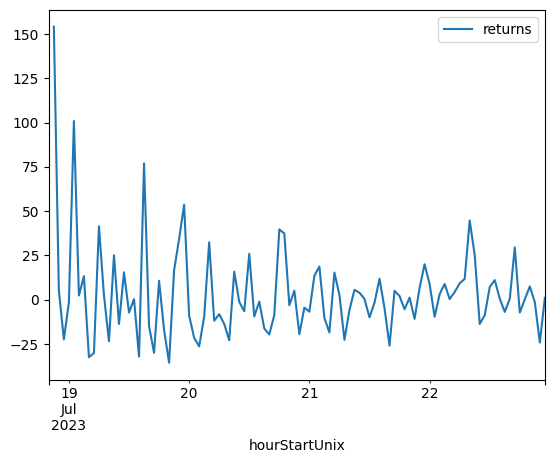

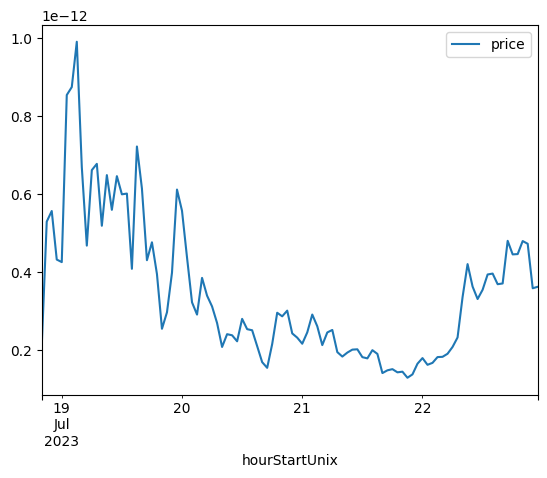

In [7]:
# plot returns for a pair and price for a pair
import matplotlib.pyplot as plt
import numpy as np

pair_data_dict['0x58c23378f238f3f35e972b50a95fcc5d4b8c94cf'].plot(x='hourStartUnix', y='returns')
pair_data_dict['0x58c23378f238f3f35e972b50a95fcc5d4b8c94cf'].plot(x='hourStartUnix', y='price')

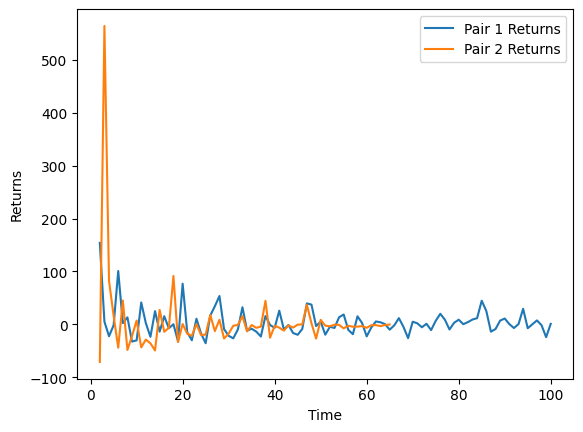

In [12]:
#just playing with plotting two things on the same graph
import matplotlib.pyplot as plt
import numpy as np

# Assuming pair_data_dict is your dictionary of DataFrames
df1 = pair_data_dict['0x58c23378f238f3f35e972b50a95fcc5d4b8c94cf']
df2 = pair_data_dict['0x6f029aa1a0f66cdadddf7665170c950130813317']

# Get the axis object from the first plot
ax = df1.plot(x='row_num', y='returns', label='Pair 1 Returns')

# Plot the returns of the second pair on the same axis
df2.plot(x='row_num', y='returns', ax=ax, label='Pair 2 Returns')

# Customize the plot (optional)
ax.set_ylabel('Returns')
ax.set_xlabel('Time')
ax.legend()

# Show the plot
plt.show()

### Plot returns with predictions

/usr/local/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/usr/local/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/usr/local/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/usr/local/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)


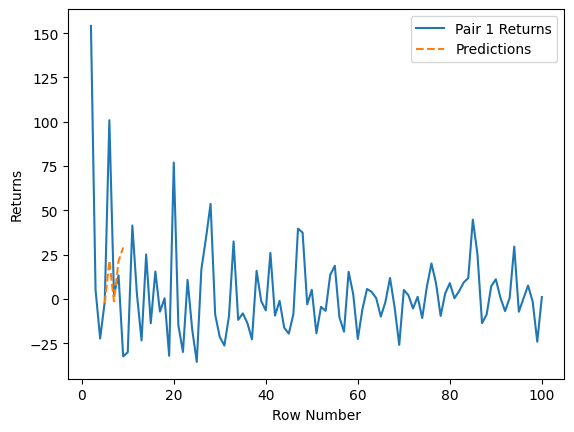

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Your existing data preparation and model training code
# ...

df2 = pair_data_dict['0x6f029aa1a0f66cdadddf7665170c950130813317'].drop(columns=['pairAddress', 'hourStartUnix'])
# Prepare the input data for prediction (5 steps after row number 20)
#start_row = 20
#steps = 10
start_row = 2
steps = 5
#X_predict = train_data.iloc[start_row:start_row+steps].drop(columns=['returns'])
X_predict = df2.iloc[start_row:start_row+steps].drop(columns=['returns'])

# Generate predictions
predictions = regressor.predict(X_predict)

# Create a DataFrame for the predictions
prediction_df = X_predict.copy()
prediction_df['predictions'] = predictions
prediction_df['row_num'] = train_data.iloc[start_row:start_row+steps].index  # Assuming the index represents the row number

# Get the axis object from the first plot
ax = df1.plot(x='row_num', y='returns', label='Pair 1 Returns')

# Plot the returns of the second pair on the same axis
#df2.plot(x='row_num', y='returns', ax=ax, label='Pair 2 Returns')

# Plot the predictions on the same axis
prediction_df.plot(x='row_num', y='predictions', ax=ax, linestyle='--', label='Predictions')

# Customize the plot (optional)
ax.set_ylabel('Returns')
ax.set_xlabel('Row Number')
ax.legend()

# Show the plot
plt.show()

# THIS IS THE ONE THAT WORKS